In [2]:
import pickle
import numpy as np

with open('data/SMRT/coefficients.pkl', 'rb') as file:
    preds = pickle.load(file)
    np_preds = {}
    for name in preds:
        np_preds[name] = preds[name].detach().cpu().numpy()
    preds = np_preds
    np.save('data/SMRT/coefficients.npy', preds)

with open('data/SMRT/adjacencies.pkl', 'rb') as file:
    adj = pickle.load(file)
    np.save('data/SMRT/adjacencies.npy', adj)

with open('data/SMRT/distances.pkl', 'rb') as file:
    dist = pickle.load(file)
    np.save('data/SMRT/distances.npy', dist)

In [3]:
loaded_data = np.load('data/SMRT/coefficients.npy', allow_pickle=True)
loaded_data.item()

{'53165246': array([[ 0.03400141, -0.00583858,  0.07739245, ...,  0.        ,
          0.        ,  0.        ],
        [-0.01797326,  0.02015996,  0.12148575, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.03123577, -0.04345091,  0.11067668, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.00124923,  0.10113704,  0.45313245, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.01651055,  0.10054582,  0.47651252, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00410183,  0.10862612,  0.49519014, ...,  0.        ,
          0.        ,  0.        ]], shape=(53, 127), dtype=float32),
 '292850': array([[-0.00789228,  0.01183016,  0.04673364, ...,  0.        ,
          0.        ,  0.        ],
        [-0.00168457,  0.00806993,  0.05681827, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.00080399,  0.00999388,  0.04026395, ...,  0.        ,
          0.        ,  0.        ],
        ...,


In [4]:
import csv

smiles = {}
retention_time = {}
with open('data/SMRT/SMART_dataset_enn_short.csv') as file:
    reader = csv.reader(file, delimiter=';')
    for line in reader:
        smiles[line[0]] = line[1]
        retention_time[line[0]] = float(line[2])

In [5]:
key = '53165246'
print(preds[key])
print(adj[key])
print(dist[key])
print(retention_time[key])
print(smiles[key])

[[ 0.03400141 -0.00583858  0.07739245 ...  0.          0.
   0.        ]
 [-0.01797326  0.02015996  0.12148575 ...  0.          0.
   0.        ]
 [ 0.03123577 -0.04345091  0.11067668 ...  0.          0.
   0.        ]
 ...
 [ 0.00124923  0.10113704  0.45313245 ...  0.          0.
   0.        ]
 [ 0.01651055  0.10054582  0.47651252 ...  0.          0.
   0.        ]
 [-0.00410183  0.10862612  0.49519014 ...  0.          0.
   0.        ]]
[[0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[0. 1. 2. ... 6. 4. 4.]
 [1. 0. 1. ... 5. 3. 3.]
 [2. 1. 0. ... 6. 4. 4.]
 ...
 [6. 5. 6. ... 0. 4. 4.]
 [4. 3. 4. ... 4. 0. 2.]
 [4. 3. 4. ... 4. 2. 0.]]
780.8
O=S(=O)(c1ccc2c(c1)CCCC2)N1CCCn2nc(-c3cccnc3)cc2C1


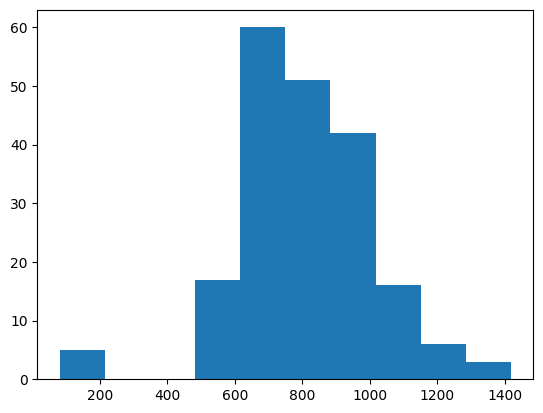

In [6]:
from matplotlib import pyplot as plt

plt.hist(list(retention_time.values()))
plt.show()

In [7]:
from rdkit import Chem
from rdkit.Chem import AllChem

mols = {}
fps = {}

fpgen = AllChem.GetRDKitFPGenerator()

for key in smiles:
    mol = Chem.MolFromSmiles(smiles[key])
    mols[key] = mol
    fps[key] = fpgen.GetFingerprint(mol)

In [8]:
# lets get pairwise

from rdkit import DataStructs

retention_diff = {}
tanimoto_sim = {}

keys = list(preds.keys())
sim_pairs = []

for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        sim_pairs.append((keys[i], keys[j]))

for key in sim_pairs:
    retention_diff[key] = abs(retention_time[key[0]] - retention_time[key[1]])
    tanimoto_sim[key] = DataStructs.TanimotoSimilarity(fps[key[0]], fps[key[1]])

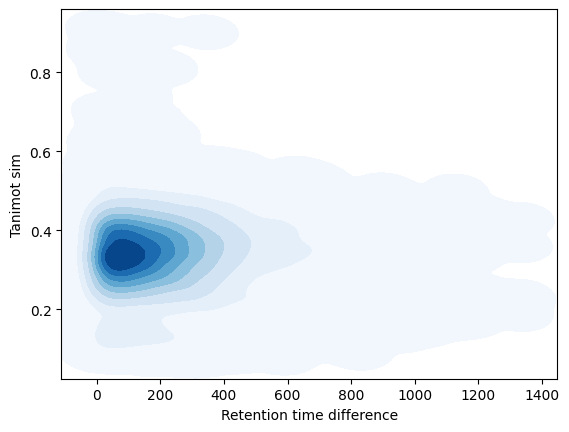

In [9]:
import seaborn as sns

x = []
y = []
for key in sim_pairs:
    x.append(retention_diff[key])
    y.append(tanimoto_sim[key])

sns.kdeplot(x=x, y=y, fill=True, cmap="Blues", thresh=0.00001)
plt.ylabel('Tanimot sim')
plt.xlabel('Retention time difference')
plt.show()

In [10]:
import ot
from tqdm import tqdm
import numpy as np

def calculate_gw_distance(node_features_1, distance_1, node_features_2, distance_2):
    
    # Define Distributions
    # We assume uniform distribution (each point has equal weight)
    p = ot.unif(node_features_1.shape[0])
    q = ot.unif(node_features_2.shape[0])

    # Calculate the Feature Distance Matrix (M)
    # M[i, j] is the distance between feature vector of node i in G1 and node j in G2
    # metric='euclidean' is standard, but you can use 'sqeuclidean', 'cosine', etc.
    M = ot.dist(node_features_1, node_features_2, metric='euclidean')

    # The alpha parameter controls the trade-off:
    # alpha = 0: Pure Gromov-Wasserstein (Structure only)
    # alpha = 1: Pure Wasserstein (Features only)
    # 0 < alpha < 1: Fused (Both)
    alpha = 0.25
    
    # fused_gromov_wasserstein2 returns the actual distance value (scalar)
    gw_dist = ot.gromov.fused_gromov_wasserstein2(
        M,
        distance_1, 
        distance_2, 
        p, 
        q, 
        loss_fun='square_loss',
        alpha=alpha,
        verbose=False,
    )
    
    return gw_dist


gw_dist = {}

for key in tqdm(sim_pairs):
    gw_dist[key] = calculate_gw_distance(preds[key[0]], dist[key[0]], preds[key[1]], dist[key[1]])

gw_dist

100%|██████████| 18528/18528 [00:43<00:00, 424.61it/s]


{('53165246', '292850'): np.float64(2.022919806881842),
 ('53165246', '53074813'): np.float64(1.587785361911477),
 ('53165246', '53133218'): np.float64(1.491236234422609),
 ('53165246', '53018843'): np.float64(1.3747850919898879),
 ('53165246', '87051331'): np.float64(2.2776942551241888),
 ('53165246', '53175209'): np.float64(1.3765836205584798),
 ('53165246', '46394732'): np.float64(1.4568982945068332),
 ('53165246', '53141103'): np.float64(1.459962002202451),
 ('53165246', '18575643'): np.float64(1.2067644110809854),
 ('53165246', '53012019'): np.float64(1.335024032680878),
 ('53165246', '83282947'): np.float64(1.1509740430566888),
 ('53165246', '49666968'): np.float64(0.9951485680376767),
 ('53165246', '71837919'): np.float64(1.814050427147172),
 ('53165246', '49665985'): np.float64(1.1589837000093908),
 ('53165246', '53133954'): np.float64(2.290743734570486),
 ('53165246', '124045368'): np.float64(1.1356572052446914),
 ('53165246', '50836000'): np.float64(1.3977042634707335),
 ('53

In [11]:
keys = list(retention_time.keys())
gw_dist_matrix = np.zeros((len(keys), len(keys)))
for pair in sim_pairs:
    distance = gw_dist[pair]
    key1 = pair[0]
    key2 = pair[1]
    idx1 = keys.index(key1)
    idx2 = keys.index(key2)
    gw_dist_matrix[idx1][idx2] = distance
    gw_dist_matrix[idx2][idx1] = distance
    
retention_time_list = np.zeros(len(keys))
for i in range(len(keys)):
    retention_time_list[i] = retention_time[keys[i]]

/home/iwe20/Projects/EDDDe/.venv/lib/python3.11/site-packages/sklearn/manifold/_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


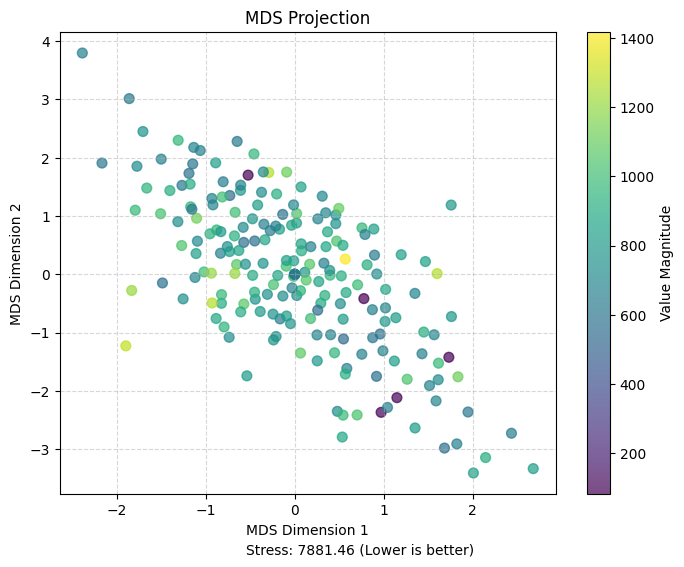

In [12]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress='auto')
coords_2d = mds.fit_transform(gw_dist_matrix)

plt.figure(figsize=(8, 6))

scatter = plt.scatter(coords_2d[:, 0], coords_2d[:, 1], 
                        c=retention_time_list, 
                        cmap='viridis', # 'viridis' is great for spotting gradients
                        s=50,          # Dot size
                        alpha=0.7)

plt.colorbar(scatter, label='Value Magnitude')
plt.title('MDS Projection')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)

# Add Stress value to caption (Lower stress = better representation of distances)
plt.figtext(0.5, 0.01, f"Stress: {mds.stress_:.2f} (Lower is better)", 
            wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

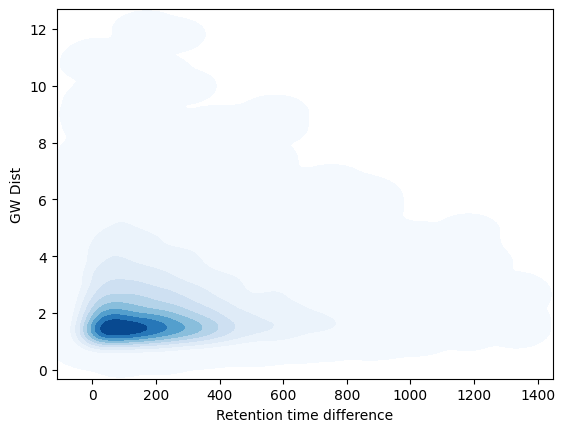

In [13]:
x = []
y = []
for key in sim_pairs:
    x.append(retention_diff[key])
    y.append(gw_dist[key])

sns.kdeplot(x=x, y=y, fill=True, cmap="Blues", thresh=0.00001)
plt.ylabel('GW Dist')
plt.xlabel('Retention time difference')
plt.show()

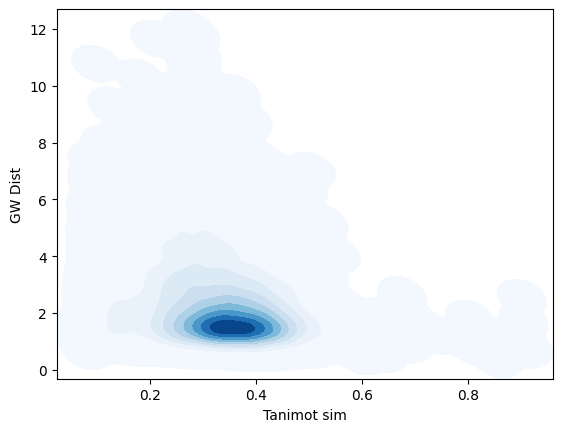

In [14]:
x = []
y = []
for key in sim_pairs:
    x.append(tanimoto_sim[key])
    y.append(gw_dist[key])

sns.kdeplot(x=x, y=y, fill=True, cmap="Blues", thresh=0.00001)
plt.ylabel('GW Dist')
plt.xlabel('Tanimot sim')
plt.show()

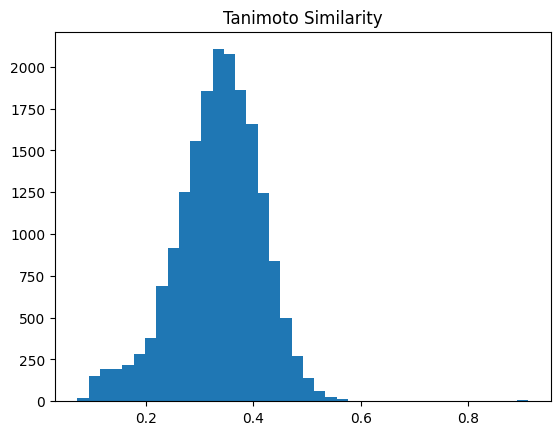

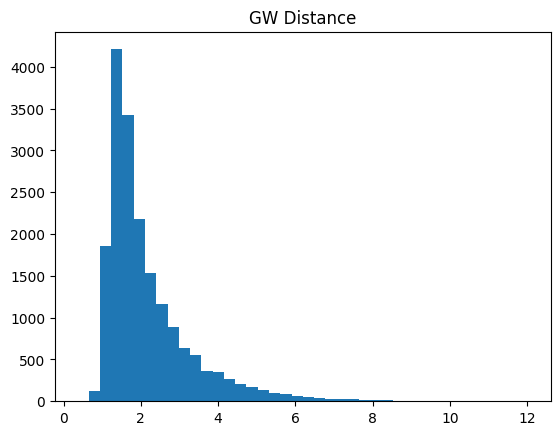

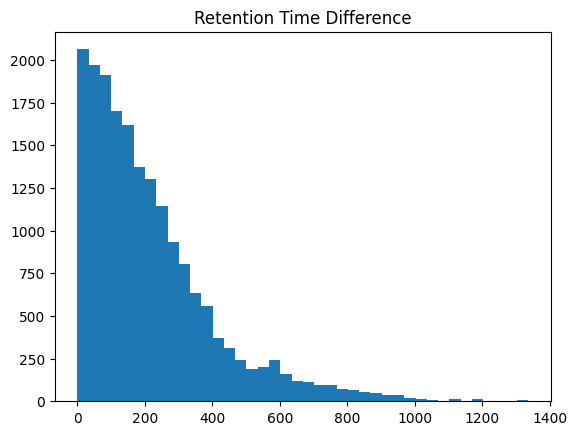

In [15]:
x = []
y = []
z = []
for key in sim_pairs:
    x.append(tanimoto_sim[key])
    y.append(gw_dist[key])
    z.append(retention_diff[key])


plt.hist(x, bins=40)
plt.title('Tanimoto Similarity')
plt.show()
plt.hist(y, bins=40)
plt.title('GW Distance')
plt.show()
plt.hist(z, bins=40)
plt.title('Retention Time Difference')
plt.show()

In [16]:
with open('data/welQrate/AID435034/coefficients.pkl', 'rb') as file:
    preds = pickle.load(file)
    np_preds = {}
    for name in preds:
        np_preds[name] = preds[name].detach().cpu().numpy()
    preds = np_preds
    np.save('data/welQrate/AID435034/coefficients.npy', preds)

with open('data/welQrate/AID435034/distances.pkl', 'rb') as file:
    dist = pickle.load(file)
    np.save('data/welQrate/AID435034/distances.npy', dist)

with open('data/welQrate/AID435034/adjacencies.pkl', 'rb') as file:
    adj = pickle.load(file)
    np.save('data/welQrate/AID435034/adjacencies.npy', adj)

active_keys = []
inactive_keys = []
with open('data/welQrate/AID435034/AID435034_enn.csv') as file:
    for line in file:
        line = line.strip().split(';')
        if line[0] in preds:
            if line[2] == 'active':
                active_keys.append(line[0])
            elif line[2] == 'inactive':
                inactive_keys.append(line[0])

print(len(preds), len(active_keys), len(inactive_keys))

264 75 189


In [17]:
a_a_gw = []
i_i_gw = []
a_i_gw = []

for i in tqdm(range(len(active_keys))):
    for j in range(i+1, len(active_keys)):
        key1 = active_keys[i]
        key2 = active_keys[j]
        a_a_gw.append(calculate_gw_distance(preds[key1], dist[key1], preds[key2], dist[key2]))

for i in tqdm(range(len(inactive_keys))):
    for j in range(i+1, len(inactive_keys)):
        key1 = inactive_keys[i]
        key2 = inactive_keys[j]
        i_i_gw.append(calculate_gw_distance(preds[key1], dist[key1], preds[key2], dist[key2]))

for i in tqdm(range(len(inactive_keys))):
    for j in range(len(active_keys)):
        key1 = inactive_keys[i]
        key2 = active_keys[j]
        a_i_gw.append(calculate_gw_distance(preds[key1], dist[key1], preds[key2], dist[key2]))

100%|██████████| 189/189 [00:33<00:00,  5.64it/s]


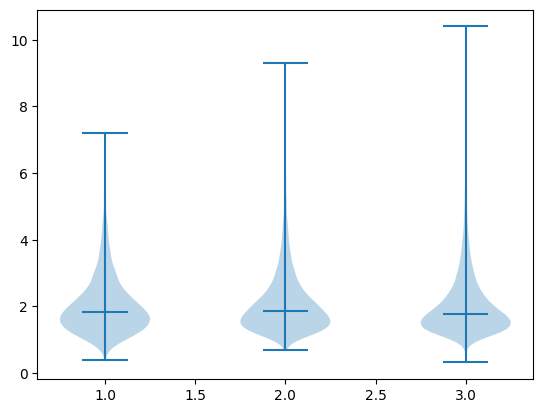

In [18]:
plt.violinplot([a_a_gw, a_i_gw, i_i_gw], showextrema=True, showmedians=True)
plt.show()

In [19]:
tani_gw_agreements = []
tani_gw_disagreements = []

for key in sim_pairs:
    if tanimoto_sim[key] > 0.8 and gw_dist[key] < 2:
        tani_gw_agreements.append(key)
    if tanimoto_sim[key] < 0.2 and gw_dist[key] < 1:
        tani_gw_disagreements.append(key)

print(len(tani_gw_agreements))
print(len(tani_gw_disagreements))

13
10


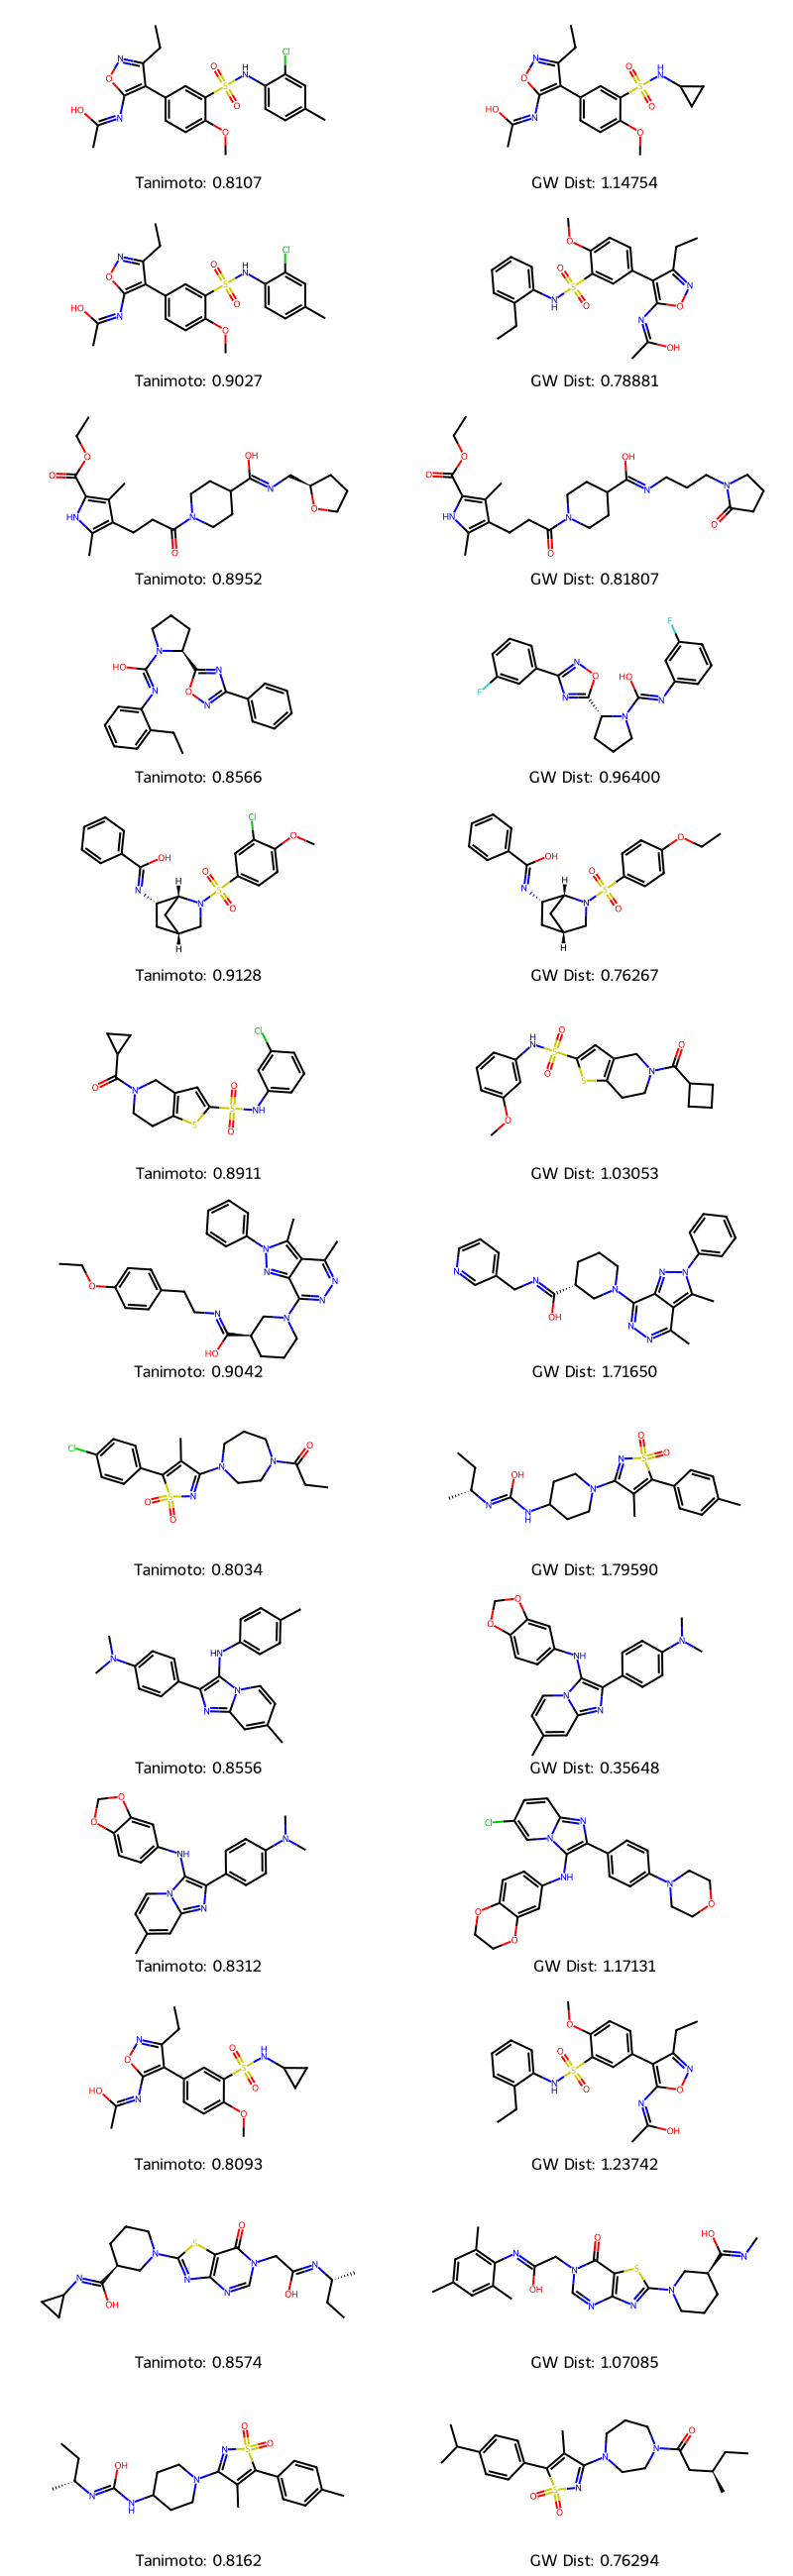

In [20]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

draw = []
leg = []
for key in tani_gw_agreements:
    draw.append(mols[key[0]])
    draw.append(mols[key[1]])
    leg.append("Tanimoto: " + f"{tanimoto_sim[key]:.4f}")
    leg.append("GW Dist: " + f"{gw_dist[key]:.5f}")
Draw.MolsToGridImage(draw, molsPerRow=2, subImgSize=(400,200), legends=leg)


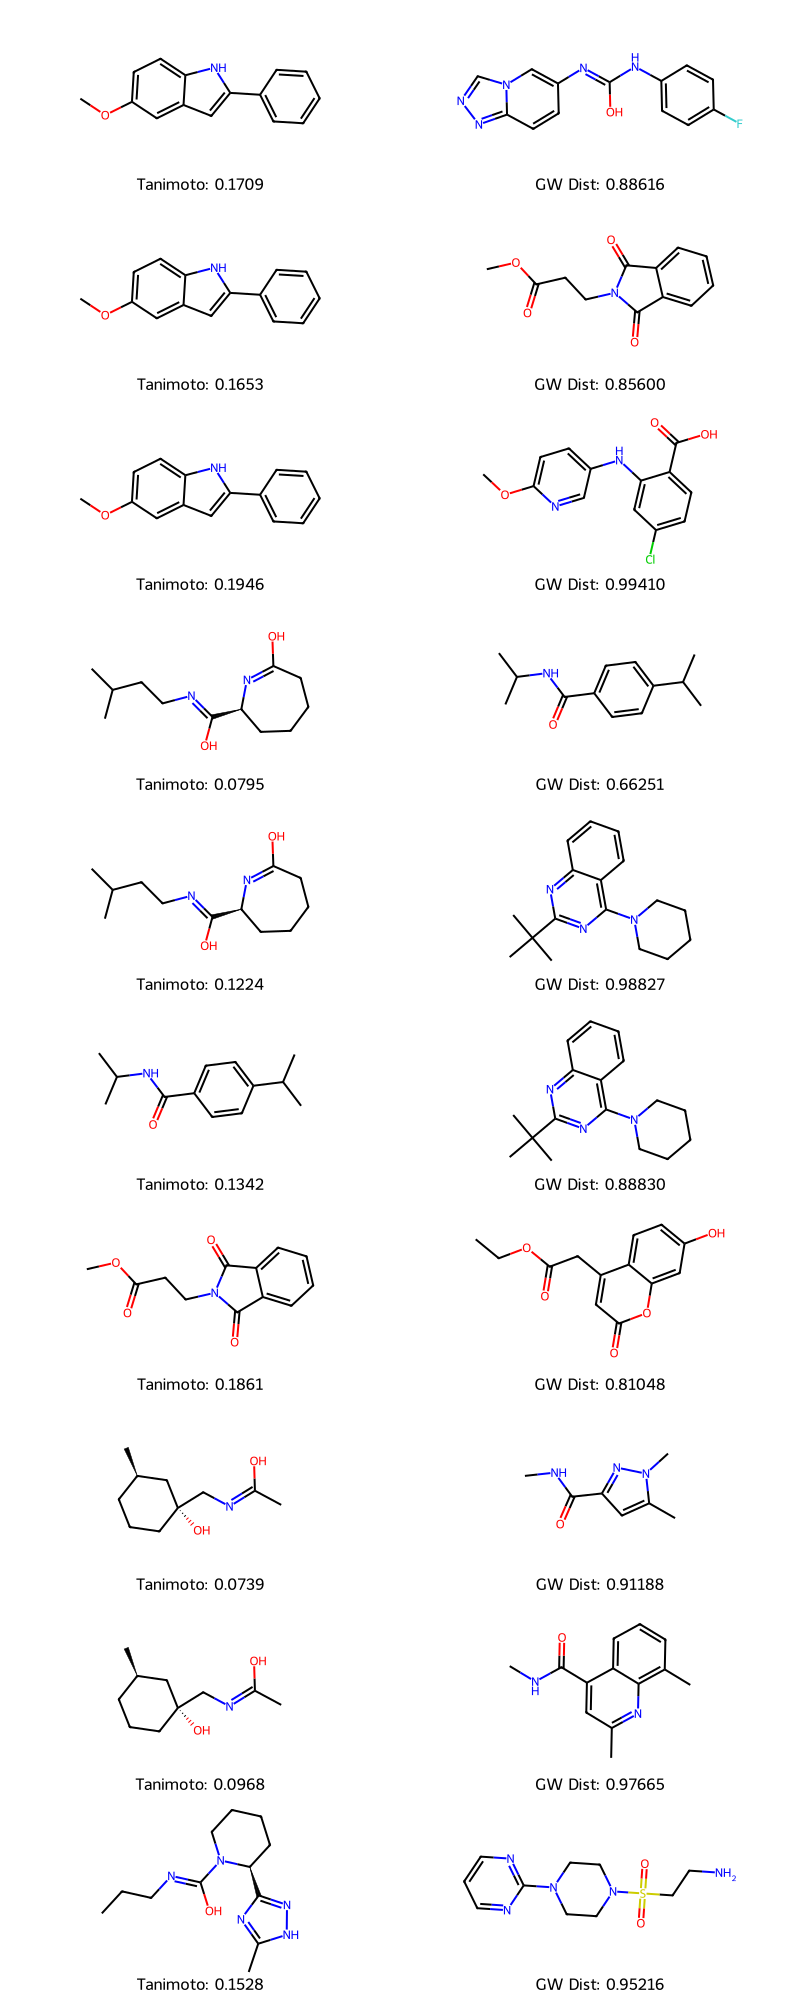

In [21]:
draw = []
leg = []
for key in tani_gw_disagreements:
    draw.append(mols[key[0]])
    draw.append(mols[key[1]])
    leg.append("Tanimoto: " + f"{tanimoto_sim[key]:.4f}")
    leg.append("GW Dist: " + f"{gw_dist[key]:.5f}")
Draw.MolsToGridImage(draw, molsPerRow=2, subImgSize=(400,200), legends=leg)

In [22]:
with open('/home/iwe20/Projects/ElektroNN/elektronn/models/basisfunction_params.pkl', 'rb') as file:
    basis = pickle.load(file)

basis[1]

{'exp': tensor([15.6753,  3.6064,  1.2080,  0.4727,  0.2018,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  2.0281,  2.0281,
          2.0281,  0.5359,  0.5359,  0.5359,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          2.2165,  2.2165,  2.2165,  2.2165,  2.2165,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.

In [23]:
basis.keys()

dict_keys([1.0, 6.0, 7.0, 8.0, 9.0, 16.0, 17.0])